# Introduction to VoxelMorph

This is a short tutorial to get started with VoxelMorph: deep-learning based registration. We aim with this notebook to shortly introduce the framework. 
<br/>
<br/>
[VoxelMorph Paper](https://arxiv.org/pdf/1809.05231.pdf).
<br/>

Outline :

- Deal with Data (MNIST)
- First Registration
- Visual Plot
- Handle many channels


# Preamble
## Setup of environment

In [41]:
# install voxelmorph, which will also install dependencies: neurite and pystrum --> useless with torch
!pip install voxelmorph 

  Using cached voxelmorph-0.1-py3-none-any.whl (75 kB)
  Using cached neurite-0.1-py3-none-any.whl (86 kB)
  Using cached pystrum-0.1-py3-none-any.whl (18 kB)


We'll start with some common imports

In [2]:
# imports
import os, sys

# third party imports
import numpy as np

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Data 
We're going to start by registering 2D MNIST digits. If the data is small (like 2D MNIST), you can often load it in memory, which enables for faster training and testing. If the data is large (large 3D scans), we will likely need to load the scans on demand. More on this later.

First, we're going to **load the data**. 


In [3]:
import torchvision
import torchvision.transforms as transforms 

from torch.utils.data import DataLoader, Dataset, TensorDataset

"""Une transformations qu'on va appliquer à notre dataset pendant qu'on le charge :
     - on pad les images en 32*32 parce que c'est une puissance de 2 c'est mieux pour le DL
     - ici on normalise 
     - enfin on convertit en Tensor"""

t = transforms.Compose([transforms.ToTensor(),
                        transforms.Pad([2,2,2,2]), 
                        transforms.Normalize(mean=(0), std=(1))]
                       )

#si jamais il est pas download dans votre ordi, set le download à True
MNIST_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=t)
MNIST_testset = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=t)

/home/luther/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
#let's get some shapes to understand what we loaded.
print('shape of train set: {}, \n\n test set: {}'.format(MNIST_trainset, MNIST_testset))

shape of train set: Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Pad(padding=[2, 2, 2, 2], fill=0, padding_mode=constant)
               Normalize(mean=0, std=1)
           ), 

 test set: Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Pad(padding=[2, 2, 2, 2], fill=0, padding_mode=constant)
               Normalize(mean=0, std=1)
           )


The MNIST dataset method __get_item__(index) just give one image. However we need 2 images for our registrating task : one __fixed__ and one __moved__, so we're going to write a dataset class that will load MNIST dataset, get only one label (as we want to registrate only on specific label) and will give two images in output.
<br/> 
Simplier methods can achieve this task but as we will need to write a Dataset class for our medical images, let's introduce the concept right now.

In [5]:
class MNIST_registration(Dataset):
    """
    Sample Pytorch Dataset. We just overwrite __getitem__ and __len__ methods.
    """
    def __init__(self, MNIST_dataset,
                 digit_sel=5):
        """
        Inputs: the dataset MNIST (train or test), the digit we want to keep and registrate
        """
        
        self.digit_sel=digit_sel
        
        # extract only instances of the digit 5
        idx=MNIST_dataset.targets==digit_sel
        MNIST_dataset.targets=MNIST_dataset.targets[idx]
        MNIST_dataset.data = MNIST_dataset.data[idx]       
        self.MNIST_dataset = MNIST_dataset
         
    def __getitem__(self, index):
        
        fix=self.MNIST_dataset.__getitem__(index)[0] #we d
        
        idx2=np.random.randint(0,len(self.MNIST_dataset),1)[0]
        moved=self.MNIST_dataset.__getitem__(idx2)[0]
        
        return (moved,fix)

    def __len__(self):
        return len(self.MNIST_dataset)

MNIST_trainset = MNIST_registration(MNIST_trainset)
MNIST_testset = MNIST_registration(MNIST_testset)

**ML detour**: separating your data in *only* train/test **often leads to problems**   
You wouldn't want to iteratively (A) build a model, (B) train on training data, and (C) test on test data  
Doing so will **overfit to you test set** (because you will have adapted your algorithm to your test data). It's a common mistakes in ML submissions.  

We will split the 'training' into 'train/validate' data, and keep the test set for later  
And will only look at the test data at the very end (once we're ready to submit the paper!) 

In [8]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np


def create_data_loaders(batch_size, valid_size, train_data, test_data):    
    
    num_train, num_test = len(train_data), len(test_data)
    
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

    # obtain training indices that will be used for validation
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_index, valid_index = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_index)
    valid_sampler = SubsetRandomSampler(valid_index)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)

    return train_loader, valid_loader, test_loader

batch_size=32
val_size=0.2

train_loader,valid_loader,test_loader=create_data_loaders(batch_size, 
                                                          val_size, 
                                                          MNIST_trainset, 
                                                          MNIST_testset)

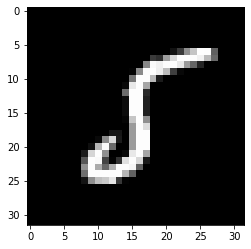

In [10]:
import matplotlib.pyplot as plt 

image, label = MNIST_trainset[0]

plt.imshow(image.reshape((32,32)),cmap='gray')

### CNN Model

Given two images (which we call *moving* and *fixed*), our goal is to find the deformation between them.
<br/>
In learning-based methods, we use a network that takes in two images $m$ ("moving") and $f$ ("fixed") (e.g. MNIST digits of size 32x32) and outputs a dense deformation $\phi$ (e.g. size 32x32x2, because at each pixel we want a vector telling us where to go). Intuitively, this deformation $\phi$ gives us the correspondances between the images, and tells us how to move the moving image to match with the fixed image. 


The [VoxelMorph](http://voxelmorph.mit.edu) library provides a `VxmDense` model class for building dense deformation networks. 

In [11]:
"""
The first thing to do is to import VoxelMorph but as we intend to use pytorch instead of tensorflow 
we need to put in our environnement (virtual or not) a key to precise it
"""
os.environ['VXM_BACKEND']='pytorch' #I set my environnement variable
#os.environ.pop('VXM_backend') if you want to clear your environnement after working with VXM
import voxelmorph as vxm

# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
inshape=32,32


# configure unet features 
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# build model
unet = vxm.networks.VxmDense(inshape=inshape, nb_unet_features=nb_features, int_steps=0)
#pour aller voir l'implémentation de UNET et vxm
#https://github.com/voxelmorph/voxelmorph/blob/dev/voxelmorph/torch/networks.py

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))
unet.to(device=device)
unet

Using device cpu


VxmDense(
  (unet_model): Unet(
    (upsample): Upsample(scale_factor=2.0, mode=nearest)
    (downarm): ModuleList(
      (0): ConvBlock(
        (main): Conv2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (2): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (3): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
    )
    (uparm): ModuleList(
      (0): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): ConvBlock(
        (mai

### Loss
<br/>
Given that the displacement $\phi$ is output from the network,  
we need to figure out a loss to tell if it makes sense
<br/>
In a **supervised setting** we would have ground truth deformations $\phi_{gt}$,  
and we could use a supervised loss like
<br/> MSE $= \| \phi - \phi_{gt} \|$
<br/>
The main idea in **unsupervised registration** is to use loss inspired by classical registration  

Without supervision, how do we know this deformation is good?  
(1) make sure that $m \circ \phi$ ($m$ warped by $\phi$) is close to $f$  
(2) regularize $\phi$ (often meaning make sure it's smooth)  
<br/>
We use two loss :
- for (1)  : classic MSE between the fixed image and the image registrated by $\phi$ (the flow flied output of the network) 
- for (2) : gradient that regularize $\phi$ (I overwrite it to match our 2D data, but its already in the voxelmorph code for 3D data)

In [13]:
class Grad:
    """
    N-D gradient loss.
    We overwrite this loss for a 2D input
    """

    def __init__(self, penalty='l1', loss_mult=None):
        self.penalty = penalty
        self.loss_mult = loss_mult

    def loss(self, _, y_pred):
        dy = torch.abs(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :])
        dx = torch.abs(y_pred[:, :, :, 1:] - y_pred[:, :, :, :-1])

        if self.penalty == 'l2':
            dy = dy * dy
            dx = dx * dx

        d = torch.mean(dx) + torch.mean(dy)
        grad = d / 3.0

        if self.loss_mult is not None:
            grad *= self.loss_mult
        return grad

In [14]:
# voxelmorph has a variety of custom loss classes
criterion = [vxm.losses.MSE().loss, Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05

optimizer=optim.Adam(unet.parameters(), lr=0.001)


### Training

In [15]:
n_epochs = 15 # number of epochs to train the model

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer, lr_scheduler=None):
    
    train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf  # set initial "min" to infinity

    for epoch in range(n_epochs):
        train_loss, valid_loss = 0, 0 # monitor losses
      
      # train the model
        model.train() # prep model for training
        
        #remember our dataset gives two images in output
        for moved, fixed in train_loader:
            moved = moved.to(device=device, dtype=torch.float32)
            fixed = fixed.to(device=device, dtype=torch.float32)
            optimizer.zero_grad() # clear the gradients of all optimized variables
            
            #in output of the network we get the flow field and the new image registrated by
            #the flow field
            registrated, flow_field = model(moved,fixed) 

            zero_phi = torch.zeros([*flow_field.shape]) #zero gradient for loss, not necessary, but it might be useful with other losses
            # calculate the loss, one with the registrated image, one with the flow field
            loss = criterion[0](fixed, registrated)+(lambda_param*criterion[1](zero_phi, flow_field)) 
            loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
            optimizer.step() # perform a single optimization step (parameter update)
            train_loss += loss.item() * moved.size(0) # update running training loss
        if lr_scheduler :
            lr_scheduler.step()
      
      # validate the model
        model.eval()
        for moved, fixed in valid_loader:
            moved = moved.to(device=device, dtype=torch.float32)
            fixed = fixed.to(device=device, dtype=torch.float32)
            
            with torch.no_grad():
                registrated, flow_field = model(moved,fixed)
            loss = criterion[0](fixed, registrated)+(lambda_param*criterion[1](zero_phi, flow_field))
            valid_loss += loss.item() * moved.size(0)
      
      # calculate average loss over an epoch
        train_loss /= len(train_loader.sampler)
        valid_loss /= len(valid_loader.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
      
        print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss
      
    return train_losses, valid_losses   

In [16]:
#RUN THE TRAINING FUNCTION
train_losses_mnist, valid_losses_mnist =training(n_epochs, 
                                         train_loader, 
                                         valid_loader, 
                                         unet, 
                                         criterion, 
                                         optimizer)

epoch: 1 	training Loss: 0.059697 	validation Loss: 0.035797
validation loss decreased (inf --> 0.035797).  Saving model ...
epoch: 2 	training Loss: 0.026678 	validation Loss: 0.019959
validation loss decreased (0.035797 --> 0.019959).  Saving model ...
epoch: 3 	training Loss: 0.017274 	validation Loss: 0.016306
validation loss decreased (0.019959 --> 0.016306).  Saving model ...
epoch: 4 	training Loss: 0.014412 	validation Loss: 0.013651
validation loss decreased (0.016306 --> 0.013651).  Saving model ...
epoch: 5 	training Loss: 0.012786 	validation Loss: 0.012108
validation loss decreased (0.013651 --> 0.012108).  Saving model ...
epoch: 6 	training Loss: 0.011683 	validation Loss: 0.011345
validation loss decreased (0.012108 --> 0.011345).  Saving model ...
epoch: 7 	training Loss: 0.011198 	validation Loss: 0.010830
validation loss decreased (0.011345 --> 0.010830).  Saving model ...
epoch: 8 	training Loss: 0.010162 	validation Loss: 0.010132
validation loss decreased (0.01083

Text(0, 0.5, 'loss value')

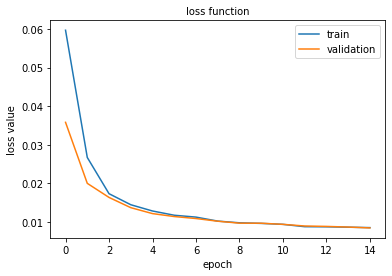

In [17]:
plt.plot(range(n_epochs), train_losses_mnist)
plt.plot(range(n_epochs), valid_losses_mnist)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)

In [18]:
unet.load_state_dict(torch.load('model.pt', map_location=device))

<All keys matched successfully>

## Plot results

In [19]:
#get some result about our model for plotting
def get_all_registration(model, loader): 
    inputs = {"moved":torch.tensor([], dtype=torch.float32),"fixed":torch.tensor([], dtype=torch.float32)}
    outputs= {"registrated":torch.tensor([], dtype=torch.float32),"flow_field":torch.tensor([], dtype=torch.float32)}
    for i,(moved, fixed) in enumerate(loader):
        moved = moved.to(device=device, dtype=torch.float32)
        fixed = fixed.to(device=device, dtype=torch.float32)
        with torch.no_grad():
            registrated, flow_field = model(moved,fixed)
            
        inputs["fixed"] = torch.cat((inputs["fixed"],fixed),dim=0)
        inputs["moved"] = torch.cat((inputs["moved"],moved),dim=0)
        outputs["registrated"] = torch.cat((outputs["registrated"],registrated),dim=0)
        outputs["flow_field"] = torch.cat((outputs["flow_field"],flow_field),dim=0)
     
    inputs["fixed"] = fixed.numpy()
    inputs["moved"] = moved.numpy()
    outputs["registrated"] = registrated.numpy()
    outputs["flow_field"] = flow_field.numpy()     
    return inputs, outputs

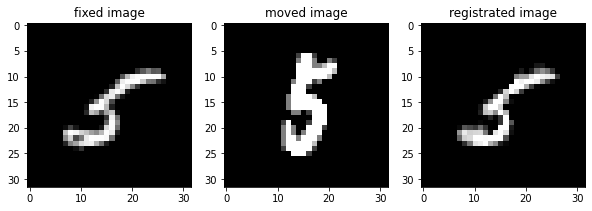

In [20]:
inputs, outputs=get_all_registration(unet, test_loader)

plt.figure(figsize=(10,15))

plt.subplot(131)
plt.imshow(inputs["fixed"][0].reshape((32,32)),cmap='gray')
plt.title("fixed image")

plt.subplot(132)
plt.imshow(inputs["moved"][0].reshape((32,32)),cmap='gray')
plt.title("moved image")

plt.subplot(133)
plt.imshow(outputs["registrated"][0].reshape((32,32)),cmap='gray')
plt.title("registrated image")

plt.show()

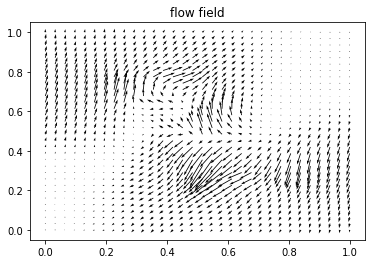

In [21]:
x,y = np.meshgrid(np.linspace(0,1,32),np.linspace(0,1,32))
u,v = outputs["flow_field"][0][0].reshape(32,32),outputs["flow_field"][0][1].reshape(32,32)
plt.quiver(x,y,u,v)
plt.title("flow field")
plt.show()

## Handle many channels
<br/>

One thing to note is that with 3D scanners, the input format is the following : (batch_size, channel=2, Height,Witdh,Lenght)
<br/>  
But when you want to "vectorize" the data (with 3D vectors instead of singular point as basic elements in the scanners) you have to triple the channel size (as if you were handling with rgb data).
<br/>
batch_size, channel=6, Height,Witdh,Lenght
<br/>
Fortunately, Voxelmorph handles that case, you just need to precise it at the creation of the model :

In [ ]:
net_with_channel=vxm.networks.VxmDense(inshape='inshape',
                                         nb_unet_features=['encoder', 'decoder'],
                                         src_feats='channel_moving_image',
                                        trg_feats='channel_fixed_image')

### But.. there is a little trick : 
<br/>
src_feats and trg_feats needs to be set at 1 when you have "normal" data and 3 when you have "vectorized" (you can even try to vectorize only the moving image or the fixed one etc..). 
<br/>  
The main trap is that it's a features implement in the github but not in the vxm files you have installed. 
The file
<br/> 

[networks](https://github.com/voxelmorph/voxelmorph/blob/dev/voxelmorph/torch/networks.py)
<br/>
in the pytorch branch of github is not the same you have upload with the pip install. 
To solve this you just need to find the voxelmorph files in your python librairies and replace the voxelmorph/torch/networks.py by the one from the github.